In [1]:
# ========================================

# Notebook: 04_modeling.ipynb

# Purpose: Fit GARCH and Stochastic Volatility (SV) models

# on training splits and visualize results

# Project: Fall 2025 Erods Institute Quant Finance Bootcamp

# ========================================

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime



In [2]:
# ----------------------------------------

# 1. Setup import paths and directories

# ----------------------------------------

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

os.makedirs("models", exist_ok=True)



In [3]:
# ----------------------------------------

# 2. Import project utilities

# ----------------------------------------

from modules.data_utils import load_split_manifest
from modules.garch_utils import fit_garch_all_assets
from modules.sv_utils import fit_sv_all_assets
from modules.plot_utils import plot_train_vols



In [4]:
# ----------------------------------------

# 3. Load training split manifest

# ----------------------------------------

# Load only pre-COVID files automatically

manifest = load_split_manifest("pre_covid")
train_paths = dict(zip(manifest["asset"], manifest["train_path"]))

#train_paths = {row["asset"]: row["train_path"] for _, row in manifest.iterrows()}
# Convert dict of asset -> path to list of paths
#train_paths_list = list(train_paths.values())


print("Training data loaded for assets:")
for asset in train_paths.keys():
    print(f"  - {asset}")



[OK] Loaded manifest for pre_covid (3 assets).
Training data loaded for assets:
  - FX_USDINR
  - BOND_BNDX
  - COM_CRUDE



--- First Calibration: Pre-COVID Training Data ---
[OK] Joint GARCH fit (normal): omega=1.023e-02, alpha=0.075, beta=0.918, NLL=5963.91
[OK] Joint GARCH fit (t): omega=7.801e-03, alpha=0.054, beta=0.918, NLL=5857.32

GARCH training files saved to /models/garch/
   -> FX_USDINR_garch_train.csv
   -> BOND_BNDX_garch_train.csv
   -> COM_CRUDE_garch_train.csv
[OK] Joint SV fit (normal): mu=-0.000000, phi=0.950000, sigma=0.200000, NLL=6245.0422
[OK] Joint SV fit (t): mu=0.000000, phi=0.950000, sigma=0.200000, NLL=6323.4794

SV training files saved to /models/sv/
   -> FX_USDINR_sv_train.csv
   -> BOND_BNDX_sv_train.csv
   -> COM_CRUDE_sv_train.csv


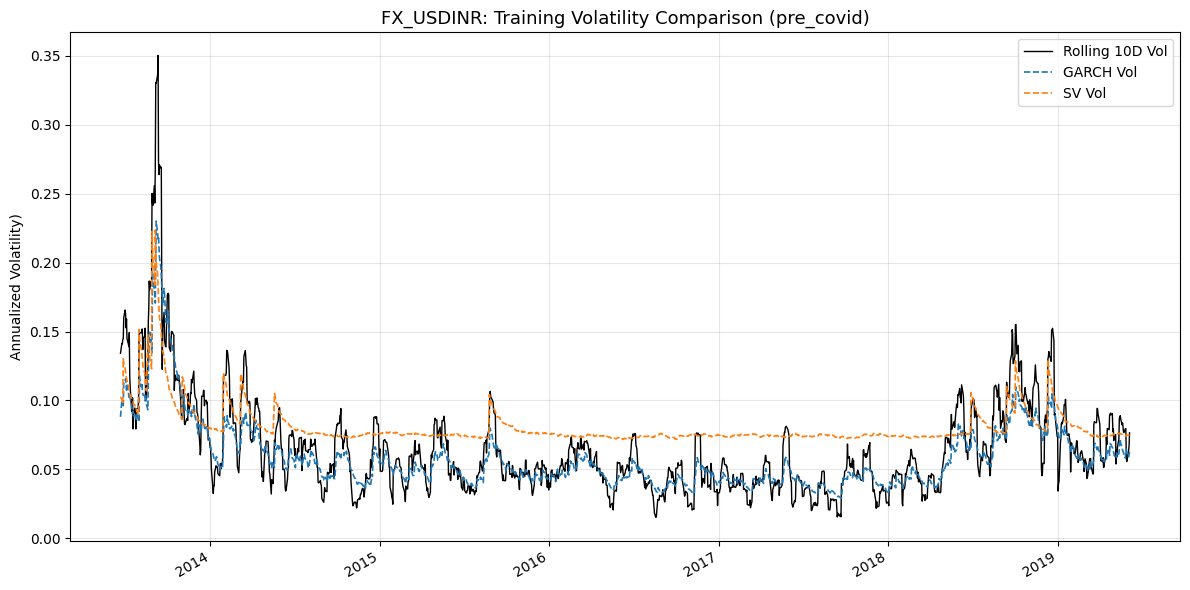

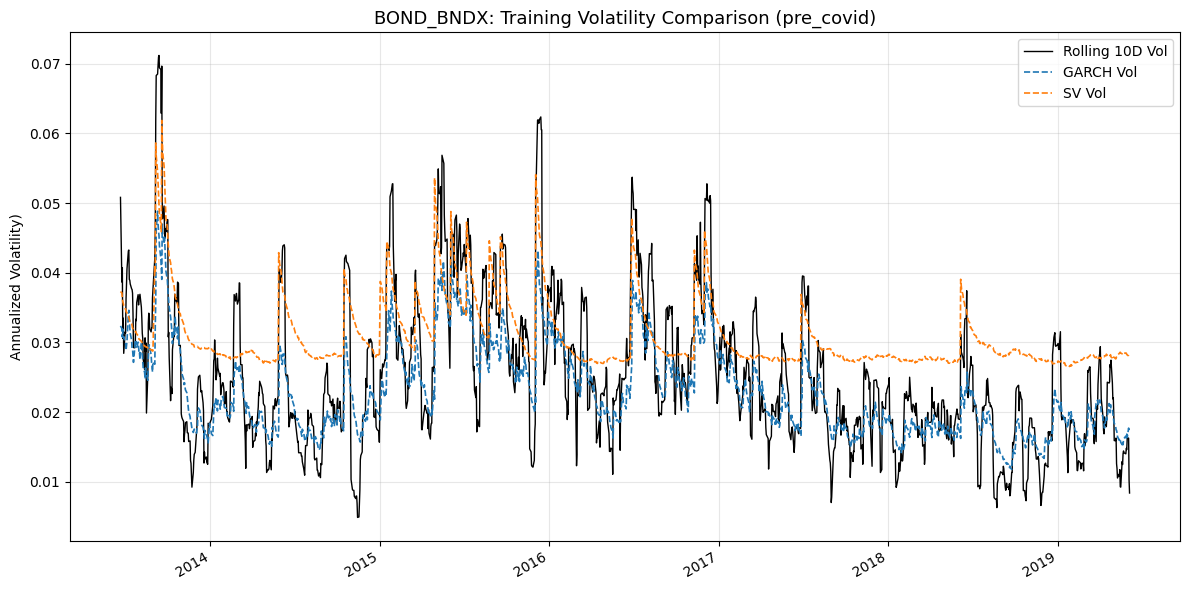

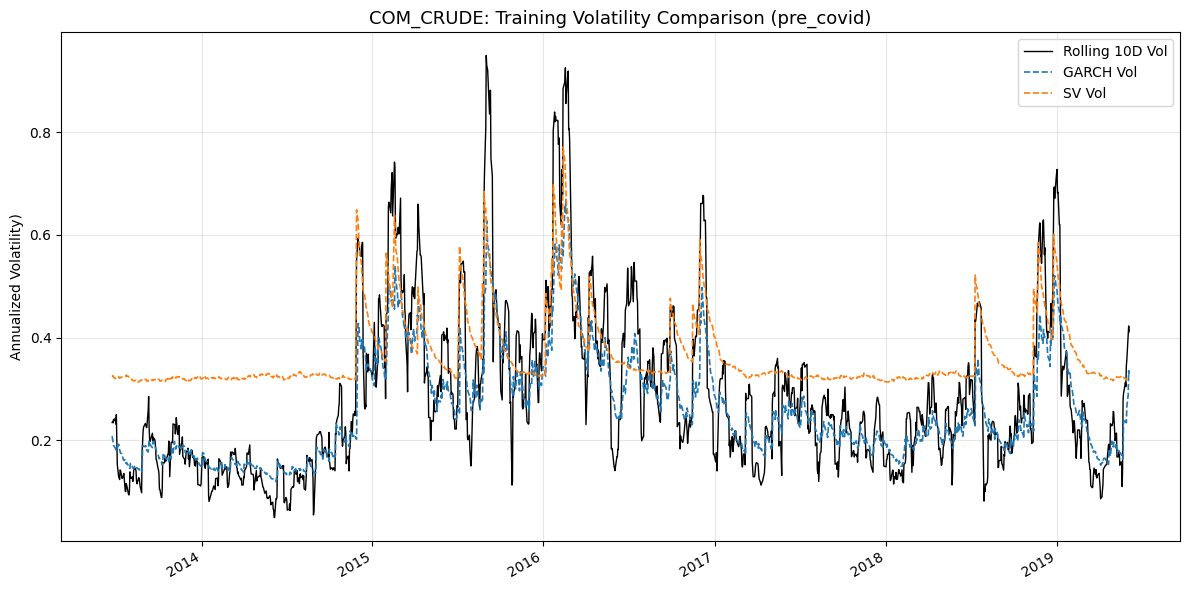

In [5]:

# ========================================

# 4. First Calibration (Pre-COVID)

# ========================================


print("\n--- First Calibration: Pre-COVID Training Data ---")

# ---------- GARCH ----------

params_norm, ll_norm, results_norm = fit_garch_all_assets(train_paths, dist="normal", calibration_label="train")
params_t, ll_t, results_t = fit_garch_all_assets(train_paths, dist="t", calibration_label="train")

# Select best distribution

if ll_t < ll_norm:
    garch_params, garch_ll, garch_results, garch_dist = params_t, ll_t, results_t, "student_t"
else:
    garch_params, garch_ll, garch_results, garch_dist = params_norm, ll_norm, results_norm, "normal"

# Save GARCH results

pd.DataFrame({
"omega": [garch_params[0]],
"alpha": [garch_params[1]],
"beta": [garch_params[2]],
"nu": [garch_params[3] if len(garch_params)==4 else None],
"distribution": [garch_dist],
"nll": [garch_ll]
}).to_csv("models/garch_params_pre_covid.csv", index=False)

os.makedirs("models/garch", exist_ok=True)
for name, df in garch_results.items():
    df.to_csv(f"models/garch/{name}_garch_train.csv", index=False)

print("\nGARCH training files saved to /models/garch/")
for name in garch_results.keys():
    print(f"   -> {name}_garch_train.csv")

# ---------- SV ----------

# ---------- Fit Stochastic Volatility (SV) Models ----------

# Fit SV with normal distribution

sv_params_norm, sv_ll_norm, sv_results_norm = fit_sv_all_assets(train_paths, dist="normal",calibration_label="train")

# Fit SV with Student-t distribution

sv_params_t, sv_ll_t, sv_results_t = fit_sv_all_assets(train_paths, dist="t", nu_fixed=8,calibration_label="train")

# Select best distribution based on NLL

if sv_ll_t < sv_ll_norm:
    sv_params, sv_ll, sv_results, sv_dist = sv_params_t, sv_ll_t, sv_results_t, "student_t"
else:
    sv_params, sv_ll, sv_results, sv_dist = sv_params_norm, sv_ll_norm, sv_results_norm, "normal"

# Extract parameters from dictionary

mu, phi, sigma_eta = sv_params




# Save SV parameters

pd.DataFrame({
"mu": [mu],
"phi": [phi],
"sigma_eta": [sigma_eta],
"distribution": [sv_dist],
"nll": [sv_ll]
}).to_csv("models/sv_params_pre_covid.csv", index=False)

# Save per-asset SV training results

os.makedirs("models/sv", exist_ok=True)
for name, df in sv_results.items():
    df.to_csv(f"models/sv/{name}_sv_train.csv", index=False)


print("\nSV training files saved to /models/sv/")
for name in sv_results.keys():
    print(f"   -> {name}_sv_train.csv")



# Diagnostic plots for training fit on training period from 2013-2019

for asset in train_paths.keys():
    plot_train_vols(asset, label="pre_covid", suffix="")





--- Second Calibration: COVID (Shock) Training Period ---
[OK] Loaded manifest for covid (3 assets).
COVID training files found: 3 assets
   → FX_USDINR
   → BOND_BNDX
   → COM_CRUDE
[OK] Joint GARCH fit (t): omega=1.061e-02, alpha=0.073, beta=0.887, NLL=2463.12
[OK] Joint SV fit (normal): mu=0.000000, phi=0.950000, sigma=0.200000, NLL=2755.3561


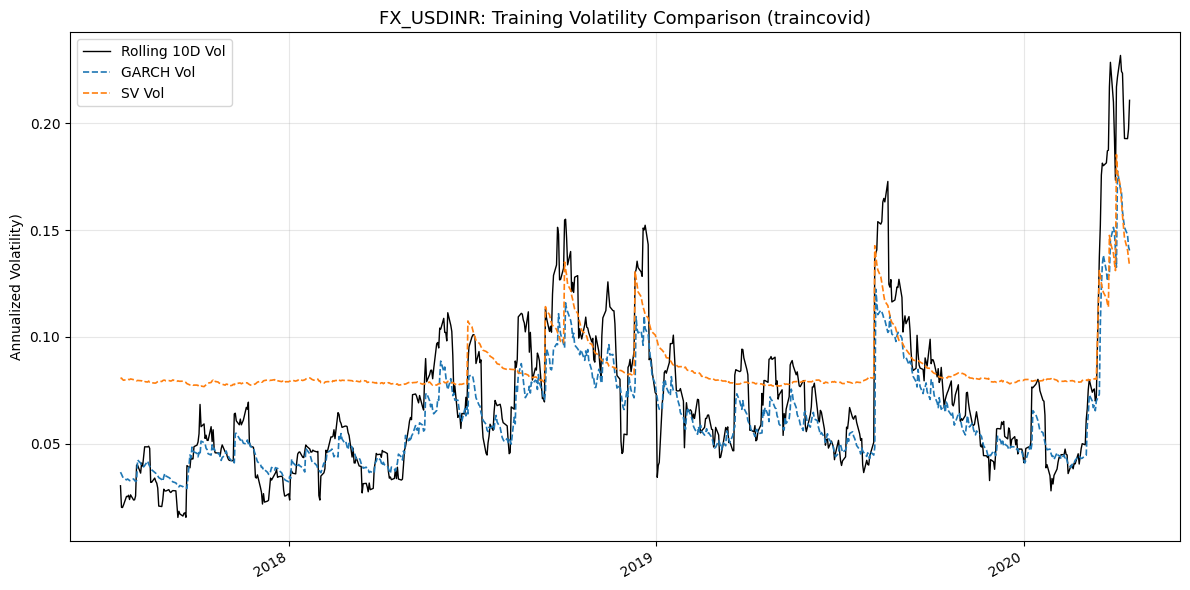

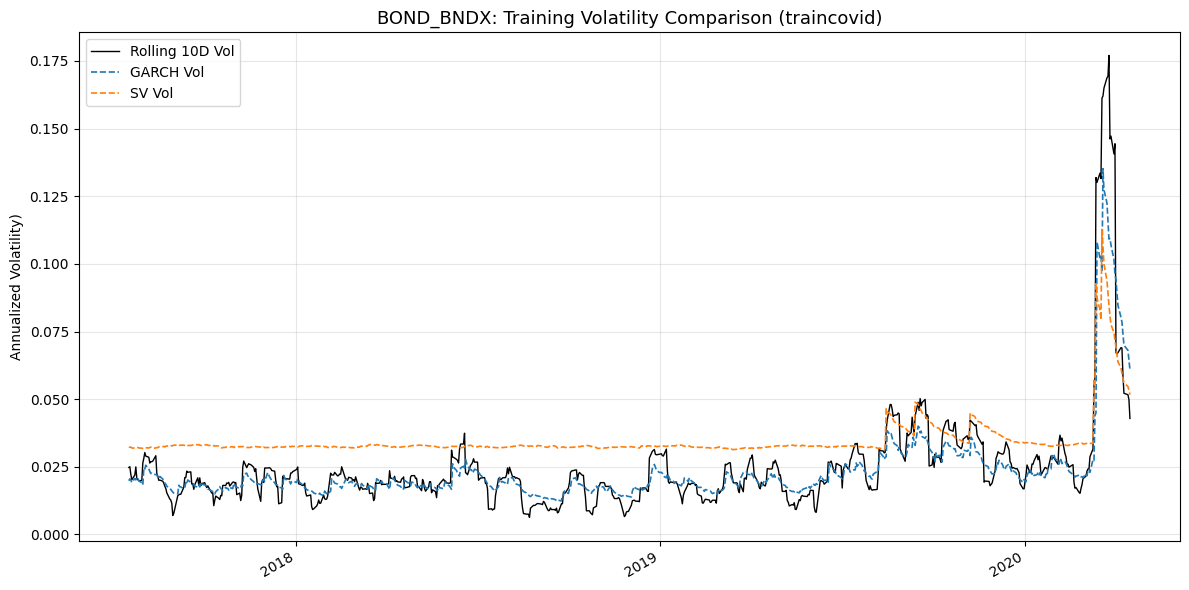

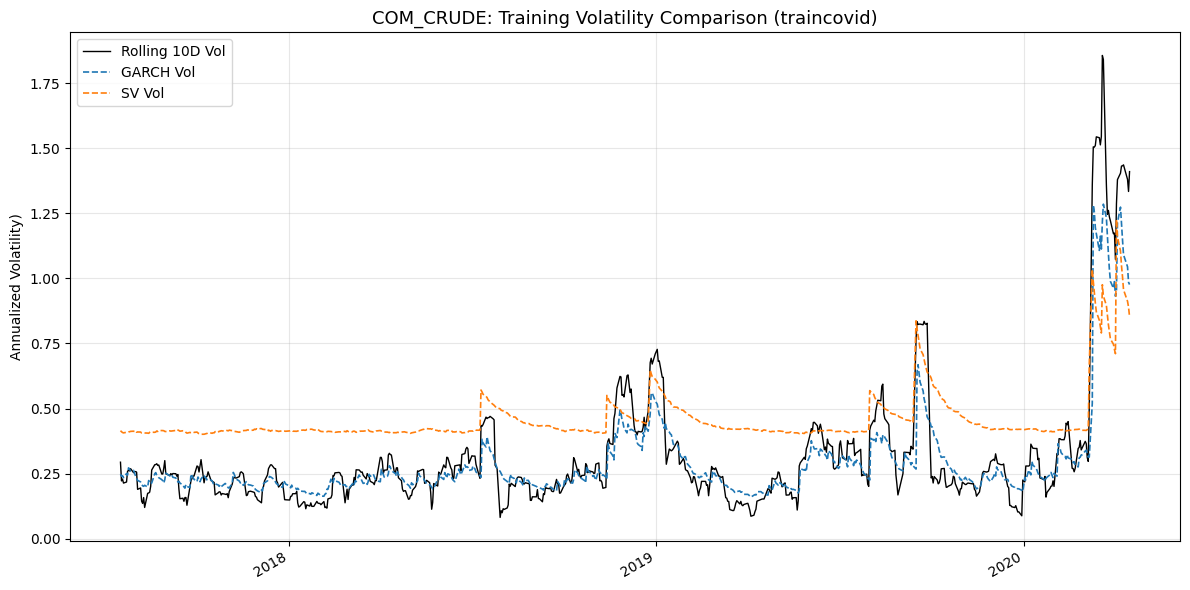


All calibrations completed successfully!


In [6]:
# %%

# ========================================

# 5. Second Calibration (Second Training Period)

# ========================================

print("\n--- Second Calibration: COVID (Shock) Training Period ---")

# already created these in split_data_global(), so just loading

manifest_covid = load_split_manifest(period="covid")
train_paths_covid = dict(zip(manifest_covid["asset"], manifest["train_path"]))

#train_paths_covid = { row["asset"]: row["train_path"]for _, row in manifest.iterrows() if "_traincovid" in row["train_path"]}

#

print(f"COVID training files found: {len(train_paths_covid)} assets")
for path in train_paths_covid:
    print(f"   → {path}")

# Define COVID training window explicitly (used by GARCH/SV fit functions)
traincovid_start = "2017-06-30"
traincovid_end   = "2020-04-15"


# ---------- GARCH ----------


params_t_covid, ll_t_covid, results_t_covid = fit_garch_all_assets(train_paths_covid, dist="t", train_start=traincovid_start,
train_end=traincovid_end, calibration_label="traincovid")

# Student t chosen as first claibration it performs better
garch_params_covid, garch_ll_covid, garch_results_covid, garch_dist_covid = params_t_covid, ll_t_covid, results_t_covid, "student_t"

# Save GARCH results

pd.DataFrame({
"omega": [garch_params_covid[0]],
"alpha": [garch_params_covid[1]],
"beta": [garch_params_covid[2]],
"nu": [garch_params_covid[3] if len(garch_params_covid)==4 else None],
"distribution": [garch_dist_covid],
"nll": [garch_ll_covid]
}).to_csv("models/garch_params_traincovid.csv", index=False)

os.makedirs("models/garch", exist_ok=True)
for name, df in garch_results_covid.items():
    df.to_csv(f"models/garch/{name}_garch_traincovid.csv", index=False)

# ---------- SV ----------

# Fit SV models for COVID training period


sv_params_norm_covid, sv_ll_norm_covid, sv_results_norm_covid = fit_sv_all_assets(train_paths_covid, dist="normal", train_start=traincovid_start,
train_end=traincovid_end, nu_fixed = 8, calibration_label="traincovid")

# Choose the best distribution based on negative log-likelihood from first calibration 


sv_params_covid, sv_ll_covid, sv_results_covid, sv_dist_covid = sv_params_norm_covid, sv_ll_norm_covid, sv_results_norm_covid, "normal"



mu, phi, sigma_eta = sv_params_covid



# Save SV parameters to CSV

pd.DataFrame({
"mu": [mu],
"phi": [phi],
"sigma_eta": [sigma_eta],
"distribution": [sv_dist_covid],
"nll": [sv_ll_covid]
}).to_csv("models/sv_params_traincovid.csv", index=False)

# Ensure directory exists and save per-asset results

os.makedirs("models/sv", exist_ok=True)
for name, df in sv_results_covid.items():
    df.to_csv(f"models/sv/{name}_sv_traincovid.csv", index=False)

# Diagnostic plots of training fit on training period from traincovid_start to traincovid_end

for asset in train_paths_covid.keys():
    plot_train_vols(asset, label="traincovid", suffix="covid")

print("\nAll calibrations completed successfully!")

